In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle
import matlab.engine


import autograd.numpy as anp
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_termination

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.population import Population

population=10
c_l = 0.002 * anp.ones(10)
c_h = 0.5 * anp.ones(10) 


In [45]:
#25000,5, 200
#36000,10, 338
#thrust=36000; vel_ship=10; rpm=338; 
#thrust=25000; vel_ship=5; rpm=200;
thrust=25000; vel_ship=5; rpm=200;
req=np.array([thrust,vel_ship,rpm])

In [46]:
eng = matlab.engine.start_matlab()

class MyProblem(Problem):
    def __init__(self, const_1=5, const_2=0.1):
        # define lower and upper bounds -  1d array with length equal to number of variable
        c_l = 0.002 * anp.ones(10)
        c_h = 0.5 * anp.ones(10)
        xl=np.append(np.array([0.01]),c_l); xu=np.append(np.array([10]),c_h)
        print('xl is:',xl,'xh is:',xu)
        super().__init__(n_var=11, n_obj=1, n_constr=0, xl=xl, xu=xu, evaluation_of="auto")
 

    def _evaluate(self, x, out, *args, **kwargs):
        f= self.ext_func(x)
        out["F"] = np.array(f).reshape(-1,1)
        
    
    def ext_func(self,x,*args,**kwargs) :
       eval=[];
       #print('X in eval is:',x)
       for i in range(len(x)):
         #print('*****************')
         test_d= np.append(req,x[i])
         #print('Design is:',test_d)
         tf = eng.OpenProp_eval(matlab.double(test_d.tolist()))
         eval.append(-1*tf)
         #print('-> Eval is:',eval)
       return eval


# Execute the optimizer 
problem = MyProblem()
termination = get_termination("n_gen", 50)
algorithm = GA(pop_size=10,
    eliminate_duplicates=True,save_history=True)
res = minimize(problem,
               algorithm,
               termination,
               seed=10,
               verbose=True,save_history=True)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
eng.quit()

data= extract_best(res)
filename='./data/GA_th'+str(thrust)+'_vs'+str(vel_ship)+'_rpm'+str(rpm)+'.csv'
np.savetxt(filename, data, delimiter=",")
#print(res.history)

xl is: [0.01  0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002] xh is: [10.   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
n_gen |  n_eval |     fopt     |     favg    
    1 |      10 | -4.12655E-01 | -1.17242E-01
    2 |      20 | -5.89243E-01 | -2.77603E-01
    3 |      30 | -5.89243E-01 | -4.64823E-01
    4 |      40 | -6.11997E-01 | -5.61183E-01
    5 |      50 | -6.45919E-01 | -6.05265E-01
    6 |      60 | -6.65115E-01 | -6.22724E-01
    7 |      70 | -6.65744E-01 | -6.46476E-01
    8 |      80 | -7.18664E-01 | -6.70669E-01
    9 |      90 | -7.19992E-01 | -6.86119E-01
   10 |     100 | -7.28833E-01 | -7.12704E-01
   11 |     110 | -7.28833E-01 | -7.21995E-01
   12 |     120 | -7.28938E-01 | -7.25440E-01
   13 |     130 | -7.32365E-01 | -7.29354E-01
   14 |     140 | -7.38347E-01 | -7.31744E-01
   15 |     150 | -7.49389E-01 | -7.36919E-01
   16 |     160 | -7.76900E-01 | -7.49263E-01
   17 |     170 | -7.78051E-01 | -7.61255E-01
   18 |     180 | -7.81102E-01 | 

In [47]:
def extract_best(res):
 data_history= res.history
 flag=0
 for d in data_history:
    pop = d.pop
    y_out= pop.get("F")
    X= pop.get("X")
    #print(pop.get("F"))
    index= np.argmin(y_out) 
    #print(('X index:',X[index]))
    #print('y index:',y_out[index])
    z=np.append(X[index],y_out[index]).reshape(1,-1)
    #print('Z is:',z)
    if flag==0:
        data=z
        flag=1
    else: 
        data= np.concatenate((data,z),axis=0)
 print('Shape of data:',data.shape)
 return data

#data=extract_best(res)

In [48]:
def load_model():
    with open('rfmodel_prop_2l', 'rb') as f:
     model=pickle.load(f)
    return model

def prop_designer(req):
    design_req= req.reshape(1,-1)
    designed_prop = model.predict(design_req)
    predicted_design=np.atleast_2d(designed_prop[0][0:12])
    predicted_eff= designed_prop[0][-1]
    print("predicted design:",predicted_design)
    print("predicted accuracy:",predicted_eff*100, '%')
    return predicted_design,predicted_eff

In [49]:
model=load_model()
design,eff= prop_designer(req)
print('shape of design:', design.shape)

/home/hv/.local/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


predicted design: [[2.21862110e-01 3.32798727e-01 2.33979180e-01 2.87128422e-01
  1.84910610e-01 2.51137876e-01 1.82581720e-01 2.55769750e-01
  2.67250635e-01 2.00000000e-03 2.25212100e+00 3.82860400e-01]]
predicted accuracy: 65.19706999999998 %
shape of design: (1, 12)


/home/hv/.local/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [50]:
eng = matlab.engine.start_matlab()
mod_design= np.append(design[0][10],design[0][0:10])
req_design= np.append(req,mod_design)
print(req_design)
tf = eng.OpenProp_eval(matlab.double(req_design.tolist()))
print('GT eff is:',tf)
eng.quit()

[2.50000000e+04 5.00000000e+00 2.00000000e+02 2.25212100e+00
 2.21862110e-01 3.32798727e-01 2.33979180e-01 2.87128422e-01
 1.84910610e-01 2.51137876e-01 1.82581720e-01 2.55769750e-01
 2.67250635e-01 2.00000000e-03]
GT eff is: 0.7019097000921434


# Using seed as starting point 

In [51]:
eng = matlab.engine.start_matlab()
population=10
problem = MyProblem()
c_l = 0.002 * anp.ones(10)
c_h = 0.5 * anp.ones(10)
x_l=np.append(np.array([0.01]),c_l); x_h=np.append(np.array([10]),c_h)
print('xl is:',x_l,'xh is:',x_h)


def create_intialseed(design,population,x_h,x_l):
   print('design from RF is:',design)
   num_design= design.shape[0]
   X_rand= np.random.random(size=(population-num_design,11))*(x_h-x_l)+ x_l 
   X= np.atleast_2d(np.append(design[0][10],design[0][0:10]))
   X= np.concatenate((X,X_rand),axis=0)
   return X


X= create_intialseed(design,population,x_h,x_l)
#X=np.atleast_2d(design[0][0:11])
#X= np.atleast_2d(np.append(design[0][10],design[0][0:10]))
#print('X is:',X)
termination = get_termination("n_gen", 50)

algorithm = GA(
    pop_size=population,
    eliminate_duplicates=True,sampling = X)

res = minimize(problem,
               algorithm,
               termination,
               seed=10,
               verbose=True,save_history=True)

eng.quit()
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
data= extract_best(res)
filename='./data/SAO_th'+str(thrust)+'_vs'+str(vel_ship)+'_rpm'+str(rpm)+'.csv'
np.savetxt(filename, data, delimiter=",")

xl is: [0.01  0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002] xh is: [10.   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
xl is: [0.01  0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002] xh is: [10.   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
design from RF is: [[2.21862110e-01 3.32798727e-01 2.33979180e-01 2.87128422e-01
  1.84910610e-01 2.51137876e-01 1.82581720e-01 2.55769750e-01
  2.67250635e-01 2.00000000e-03 2.25212100e+00 3.82860400e-01]]
n_gen |  n_eval |     fopt     |     favg    
    1 |      10 | -7.01910E-01 | -2.45777E-01
    2 |      20 | -7.01910E-01 | -5.97481E-01
    3 |      30 | -7.74746E-01 | -7.07375E-01
    4 |      40 | -7.74746E-01 | -7.29676E-01
    5 |      50 | -7.74746E-01 | -7.55017E-01
    6 |      60 | -7.80344E-01 | -7.67831E-01
    7 |      70 | -7.80344E-01 | -7.75851E-01
    8 |      80 | -7.85671E-01 | -7.80012E-01
    9 |      90 | -7.91506E-01 | -7.84275E-01
   10 |     100 | -7.91506E-01 | -7.89173E-01
   11 |  

In [52]:

data1_ga= np.loadtxt("./data/GA_th25000_vs5_rpm200.csv", delimiter=",",skiprows=0, dtype=np.float32)
data1_sao= np.loadtxt("./data/SAO_th25000_vs5_rpm200.csv", delimiter=",",skiprows=0, dtype=np.float32)


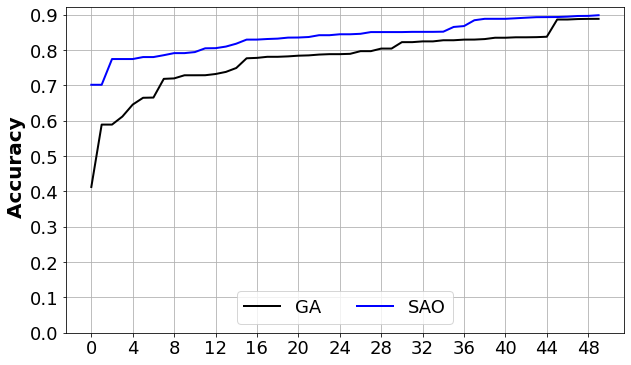

In [54]:
fig,ax=plt.subplots(figsize=(10,6))

plt.plot(-1*data1_ga[:,-1],c='black',label='GA',linewidth=2.0)
plt.plot(-1*data1_sao[:,-1],c='blue',label='SAO',linewidth=2.0)


#plt.legend(loc='best',fontsize=15)
plt.legend(loc="lower center", ncol=3,fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(np.arange(0, 52, 4))
plt.yticks(np.arange(0,1.0,0.1))
#plt.xlim(0,26)
#plt.ylim(0,1.0)
#plt.xlabel('Num of samples=index*50',fontsize=20,weight='bold')
plt.ylabel(' Accuracy',fontsize=20,weight='bold')
plt.grid()
plt.show()
#fig.savefig('../fig/comparison_result1.png', bbox_inches='tight',dpi=300)
#fig.savefig('../fig/comparison_result1.pdf', bbox_inches='tight',dpi=300) 
#fig.savefig('../fig/comparison_result_trans1.png', bbox_inches='tight',dpi=300,transparent=True) 